# Introduction

In [1]:
# Loading packages

# Path and file, data handling
import os
import h5py
import numpy as np
import pandas as pd
from pathlib import Path

# Image preprocessing
from skimage.io import imread
import cv2

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Splitting dataset
from sklearn.model_selection import train_test_split

# Image Augmentation
import imgaug as aug
import imgaug.augmenters as iaa

# Deep Learning
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Loading Data

In [7]:
# data = pd.read_csv('D:\\Projects\\Covid19\\data\\Cropped\\categorical.csv')

# # data.sample(frac=1.).reset_index(drop=True)

# data['label'].value_counts()

# Splitting Training - Validation Data

In [4]:
# Splitting data into train-validation sets

# msk = np.random.rand(len(train_data)) < 0.8
# train = train_data[msk]
# validation = train_data[~msk]

# train, validation = train_test_split(data, test_size=0.2, random_state = 42)

In [5]:
# train['label'].value_counts()

In [6]:
# validation['label'].value_counts()

# Visualizing samples in each class

COVID     590
NORMAL    579
OTHERS    445
Name: label, dtype: int64


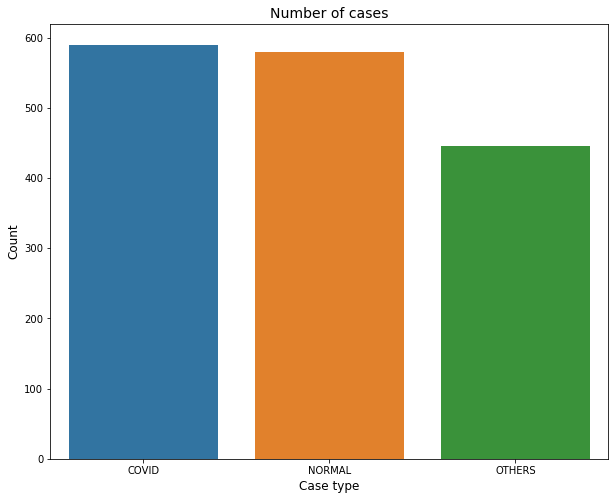

In [7]:
# Get the counts for each class

cases_count = data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['COVID', 'NORMAL', 'OTHERS'])
plt.show()

NORMAL    473
COVID     458
OTHERS    360
Name: label, dtype: int64


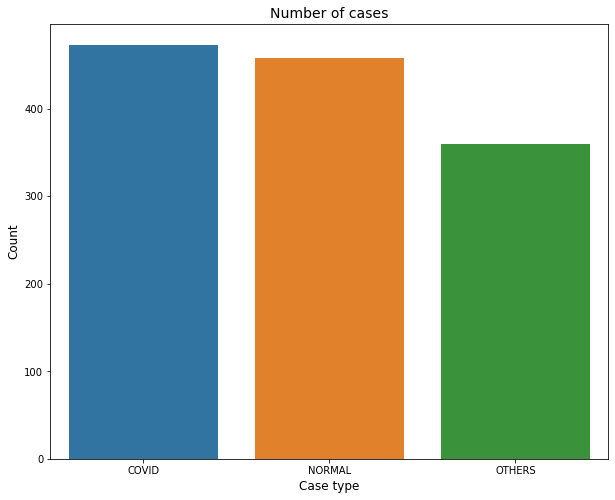

In [8]:
# Train

cases_count = train['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['COVID', 'NORMAL', 'OTHERS'])
plt.show()

COVID     132
NORMAL    106
OTHERS     85
Name: label, dtype: int64


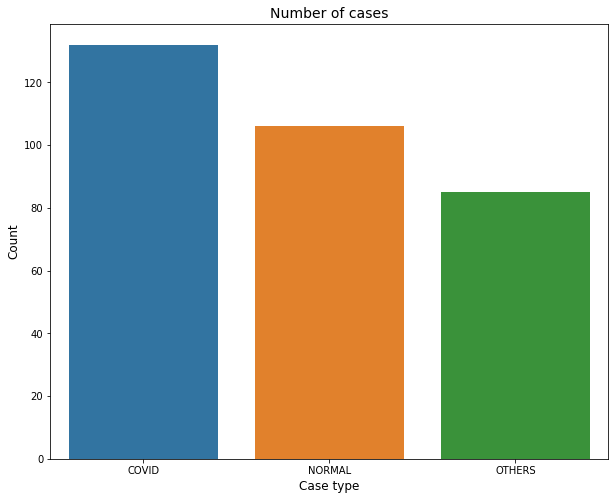

In [9]:
# validation

cases_count = validation['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['COVID', 'NORMAL', 'OTHERS'])
plt.show()

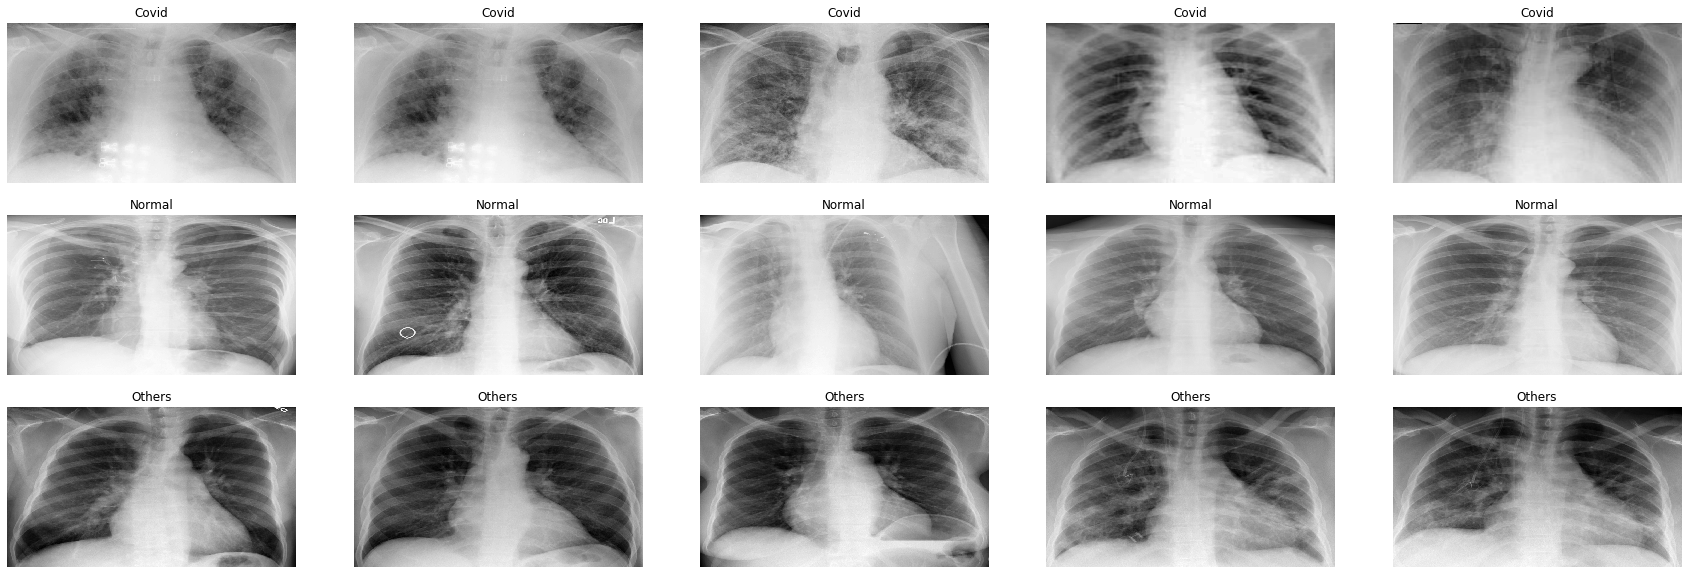

In [31]:
# Get few samples for both the classes

covid_samples = (data[data['label']=='COVID']['image'].iloc[:5]).tolist()
normal_samples = (data[data['label']=='NORMAL']['image'].iloc[:5]).tolist()
others_samples = (data[data['label']=='OTHERS']['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = covid_samples + normal_samples + others_samples
del covid_samples, normal_samples, others_samples

# Plot the data 
f, ax = plt.subplots(3,5, figsize=(30,10))
for i in range(15):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Covid")
    elif i<10:
        ax[i//5, i%5].set_title("Normal")
    else:
        ax[i//5, i%5].set_title("Others")
        
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

# Custom Data Generator

Here we will prepare and preprocess our data before feeding it to our Network. We will define custom data generator for our purpose.

## Train Generator

In [11]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=4, seed=1, target_w = 224, target_h = 224):
    
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="categorical",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [12]:
train_generator = get_train_generator(train, None, "image", "label")

getting train generator...
Found 1291 validated image filenames belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


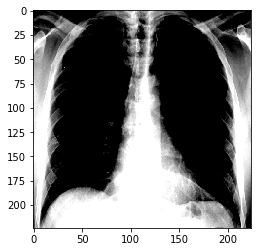

In [13]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

## Validation Generator

In [14]:
def valid_generator(valid_df, train_df, image_dir, x_col, y_cols, sample_size=1291 , batch_size=4, seed=1, target_w = 224, target_h = 224):
    
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=None, 
        x_col="image", 
        y_col="label", 
        class_mode="categorical", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="categorical",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    return valid_generator

In [15]:
valid_generator = valid_generator(validation, train, None, "image", "label")

getting train and valid generators...
Found 1291 validated image filenames belonging to 3 classes.
Found 323 validated image filenames belonging to 3 classes.


# Model

In [16]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(3, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [17]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

In [18]:
# Open the VGG16 weight file

f = h5py.File('D:/Projects/Covid19/VGG16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

In [33]:
# opt = RMSprop(lr=0.0001, decay=1e-6)

opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=10)
chkpt = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, save_weights_only=True)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [34]:
batch_size = 4
nb_epochs = 20


# Define the number of training steps
nb_train_steps = train.shape[0]//batch_size
nb_validation_steps = validation.shape[0]//batch_size


print("Number of training and validation steps: {} and {}".format(nb_train_steps, nb_validation_steps))

Number of training and validation steps: 322 and 80


In [35]:
# Fit the model

history = model.fit_generator(train_generator, epochs = nb_epochs, steps_per_epoch = nb_train_steps,
                              validation_data = valid_generator ,validation_steps = nb_validation_steps ,
                              callbacks = [es, chkpt])

Epoch 1/20
322/322 [==============================] - 249s 774ms/step - loss: 0.1425 - accuracy: 0.9472 - val_loss: 2.2224 - val_accuracy: 0.4250
Epoch 2/20
322/322 [==============================] - 237s 735ms/step - loss: 0.1172 - accuracy: 0.9596 - val_loss: 2.6640 - val_accuracy: 0.3562
Epoch 3/20
322/322 [==============================] - 240s 746ms/step - loss: 0.0905 - accuracy: 0.9736 - val_loss: 4.0465 - val_accuracy: 0.4812
Epoch 4/20
322/322 [==============================] - 252s 783ms/step - loss: 0.0807 - accuracy: 0.9713 - val_loss: 3.3458 - val_accuracy: 0.4437
Epoch 5/20
322/322 [==============================] - 261s 810ms/step - loss: 0.0713 - accuracy: 0.9782 - val_loss: 2.8992 - val_accuracy: 0.4625
Epoch 6/20
322/322 [==============================] - 248s 771ms/step - loss: 0.0532 - accuracy: 0.9837 - val_loss: 3.5860 - val_accuracy: 0.4469
Epoch 7/20
322/322 [==============================] - 254s 787ms/step - loss: 0.0468 - accuracy: 0.9829 - val_loss: 3.1404 -

# Evaluation

## Accuracy Graph

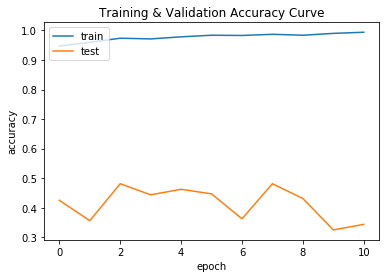

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training & Validation Accuracy Curve')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Loss Graph

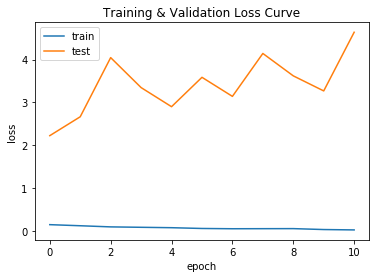

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training & Validation Loss Curve")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Reference

* [Create train-validation split](https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas)

* https://www.aylakhan.tech/?p=323

In [38]:
train_generator.class_indices

{'COVID': 0, 'NORMAL': 1, 'OTHERS': 2}